#深度卷积生成对抗网络

本教程演示了如何使用深度卷积生成对抗网络（DCGAN）生成手写数字图片。该代码是使用 **Keras Sequential API **与 `tf.GradientTape` 训练循环编写的。

##什么是生成对抗网络？
**生成对抗网络**（GANs）是当今计算机科学领域最有趣的想法之一。两个模型通过对抗过程同时训练。一个生成器（“艺术家”）学习创造看起来真实的图像，而判别器（“艺术评论家”）学习区分真假图像。
![替代文字](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

训练过程中，生成器在生成逼真图像方面逐渐变强，而判别器在辨别这些图像的能力上逐渐变强。当判别器不再能够区分真实图片和伪造图片时，训练过程达到平衡。

![替代文字](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

本笔记在 MNIST 数据集上演示了该过程。下方动画展示了当训练了 50 个epoch （全部数据集迭代50次） 时生成器所生成的一系列图片。图片从随机噪声开始，随着时间的推移越来越像手写数字。

![输出样本](https://tensorflow.google.cn/images/gan/dcgan.gif?hl=zh_cn)

要了解关于 GANs 的更多信息，我们建议参阅 [MIT的 深度学习入门](http://introtodeeplearning.com/) 课程。

###导入TensorFlow和其他库

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import,division,print_function,unicode_literals
import tensorflow as tf


In [0]:
# 用于生成 GIF 图片
# !pip install -q imageio
import imageio
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

###加载和准备数据集
您将使用 MNIST 数据集来训练生成器和判别器。生成器将生成类似于 MNIST 数据集的手写数字。

In [5]:
(train_images, train_labels),(_,_) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
train_images.shape

(60000, 28, 28)

In [0]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images - 127.5)/127.5 #将图片标准化到 [-1, 1] 区间内

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# 批量化和打乱数据
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

##创建模型
生成器和判别器均使用 Keras Sequential API 定义。

####生成器
生成器使用 [tf.keras.layers.Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose?hl=zh_cn) （上采样）层来从种子（随机噪声）中产生图片。以一个使用该种子作为输入的 `Dense `层开始，然后多次上采样直到达到所期望的 28x28x1 的图片尺寸。注意除了输出层使用 tanh 之外，其他每层均使用 [tf.keras.layers.LeakyReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU?hl=zh_cn)作为激活函数。

In [0]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None, 7,7,256) #注意: batch size 没有限制

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same', use_bias=False))
  assert model.output_shape == (None, 7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape == (None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False, activation='tanh'))
  assert model.output_shape == (None,28,28,1)

  return model

使用（尚未训练的）生成器创建一张图片。

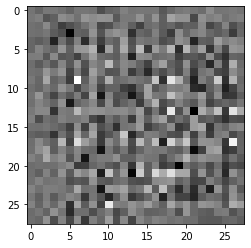

In [14]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0],cmap='gray')

###判别器
判别器是一个基于 CNN 的图片分类器。

In [0]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',
                          input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5), strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

使用（尚未训练的）判别器来对图片的真伪进行判断。模型将被训练为为真实图片输出正值，为伪造图片输出负值。

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00245531]], shape=(1, 1), dtype=float32)


###定义损失函数和优化器
为两个模型定义损失函数和优化器。

In [0]:
# 该方法返回计算交叉熵损失的辅助函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

###判别器损失
该方法量化判别器从判断真伪图片的能力。它将判别器对真实图片的预测值与值全为 1 的数组进行对比，将判别器对伪造（生成的）图片的预测值与值全为 0 的数组进行对比。

In [0]:
def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

###生成器损失
生成器损失量化其欺骗判别器的能力。直观来讲，如果生成器表现良好，判别器将会把伪造图片判断为真实图片（或 1）。这里我们将把判别器在生成图片上的判断结果与一个值全为 1 的数组进行对比。

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

由于我们需要分别训练两个网络，判别器和生成器的优化器是不同的。

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

###保存检查点
本笔记还演示了如何保存和恢复模型，这在长时间训练任务被中断的情况下比较有帮助。

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

##定义训练循环

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16


# 我们将重复使用该种子（因此在动画 GIF 中更容易可视化进度）
seed = tf.random.normal([num_examples_to_generate,noise_dim])

训练循环在生成器接收到一个随机种子作为输入时开始。该种子用于生产一张图片。判别器随后被用于区分真实图片（选自训练集）和伪造图片（由生成器生成）。针对这里的每一个模型都计算损失函数，并且计算梯度用于更新生成器与判别器。

In [0]:
# 注意 `tf.function` 的使用
# 该注解使函数被“编译”
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images,training=True)


    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output,fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))


In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # 继续进行是为 GIF生成图像
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch+1,
                             seed)
    
    # 每15个epoch保存一次模型
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time of epoch {} is {}  ses'.format(epoch + 1, time.time()-start))

  # 最后一个epoch 结束后生成图片
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

###生成与保存图片

In [0]:
def generate_and_save_images(model,epoch,test_input):
  # 注意 training` 设定为 False
  # 因此，所有层都在推理模式下运行（batchnorm）。
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]* 127.5 + 127.5,cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

##训练模型
调用上面定义的 `train()` 方法来同时训练生成器和判别器。注意，训练 GANs 可能是棘手的。重要的是，生成器和判别器不能够互相压制对方（例如，他们以相似的学习率训练）。

在训练之初，生成的图片看起来像是随机噪声。随着训练过程的进行，生成的数字将越来越真实。在大概 50 个 epoch 之后，这些图片看起来像是 MNIST 数字。使用 Colab 中的默认设置可能需要大约 1 分钟每 epoch。

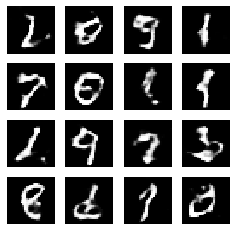

CPU times: user 1min 51s, sys: 15.1 s, total: 2min 6s
Wall time: 5min 14s


In [30]:
%%time
train(train_dataset,EPOCHS)

恢复最新的检查点。

In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

##创建GIF

In [0]:
# 使用 epoch 数生成间张图片
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

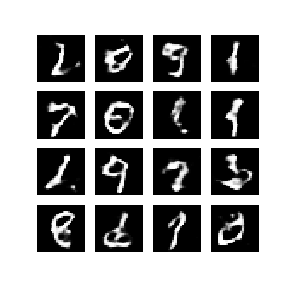

In [34]:
display_image(EPOCHS)

使用训练过程中生成的图片通过 imageio 生成动态 gif

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file,mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i ,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

如果您正在使用 Colab，您可以打开左侧文件夹查看动画：